# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

* Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи;
* Целевой признак: количество страховых выплат клиенту за последние 5 лет.

Цель проекта - предложить алгоритм преобразования данных для их защиты без ухудшения качества моделей.

### Импортируем и изучаем данные

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# Сохраняем информацию файла в датафрейме data
data = pd.read_csv('/datasets/insurance.csv')
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [3]:
# Выводим общую информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [4]:
# Проверяем на наличие явных дубликатов
data.duplicated().sum()

153

In [5]:
# Смотрим на категориальные признаки. Зарплату сразу исключим.
data_category = data.drop('Зарплата', axis=1)
for i in data_category.columns:
    print(i, ':', data_category[i].sort_values().unique())

Пол : [0 1]
Возраст : [18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 65.]
Члены семьи : [0 1 2 3 4 5 6]
Страховые выплаты : [0 1 2 3 4 5]


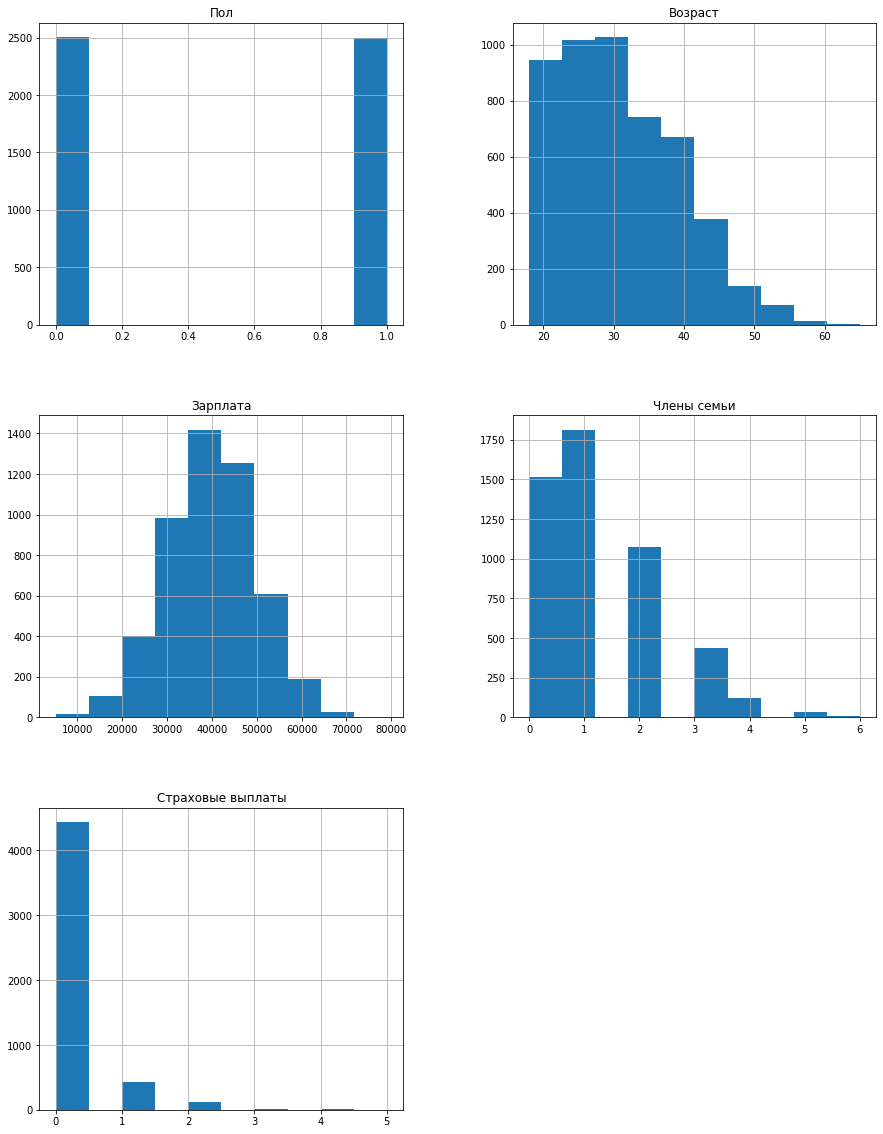

In [6]:
# Строим гистограммы, чтобы нагляднее прикоснуться к данным
data.hist(figsize=(15, 20))
None

In [7]:
# Более подробно смотрим на распределение значений 
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [8]:
# Оцениваем, как признаки коррелируют друг с другом
data.corr()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
Пол,1.000000,0.002074,0.014910,-0.008991,0.010140
Возраст,0.002074,1.000000,-0.019093,-0.006692,0.651030
Зарплата,0.014910,-0.019093,1.000000,-0.030296,-0.014963
Члены семьи,-0.008991,-0.006692,-0.030296,1.000000,-0.036290
Страховые выплаты,0.010140,0.651030,-0.014963,-0.036290,1.000000


In [1]:
cm = sns.light_palette("green", as_cmap=True)
data_corr = data.corr()
data_corr.style.background_gradient(cmap=cm).set_precision(2).highlight_min(axis=0, color='lightblue').highlight_max(axis=0, color='blue')

NameError: name 'sns' is not defined

### Вывод по данным

На основе полученных сведений о предоставленных нам данных можно сделать следующие выводы:
* Датафрейм содержит данные в 5 колонках и 5000 строках;
* Пропущенных значений нет;
* Имеется один категориальный признак - "Пол";
* В сумме имеется 153 дубликата, которые необходимо убрать, т.к. в исследовании они не пригодятся;
* Типы данных имеют корректный вид, за исключением возраста. Его нужно привести к типу int;
* Наименования столбцов приводить к змеиному регистру не будем, т.к. они вполне корректны и их слишком мало, чтобы запутаться;
* Признаки практически никак не коррелируют друг с другом. Корреляция прослеживается только возраста и страховых выплат и возраста и количества членов семьи (что, наверное, логично).

Также можно отметить, что, в среднем, клиенты:
* Находятся в возрасте 20-40 лет;
* Имеют зарплату около 40 тыс.;
* Имеют семью, состоящую из 1-2 человек;
* Практически не получают страховых выплат.

In [10]:
data = data.drop_duplicates() # Убираем дубликаты из нашего датафрейма
# data.duplicated().sum()

data['Возраст'] = data['Возраст'].astype(int) # Приводим возраст к типу int
data.info() # Проверяем

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4847 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                4847 non-null   int64  
 1   Возраст            4847 non-null   int64  
 2   Зарплата           4847 non-null   float64
 3   Члены семьи        4847 non-null   int64  
 4   Страховые выплаты  4847 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 227.2 KB


## Умножение матриц

В этом задании вы можете записывать формулы в *Jupyter Notebook.*

Чтобы записать формулу внутри текста, окружите её символами доллара \\$; если снаружи —  двойными символами \\$\\$. Эти формулы записываются на языке вёрстки *LaTeX.* 

Для примера мы записали формулы линейной регрессии. Можете их скопировать и отредактировать, чтобы решить задачу.

Работать в *LaTeX* необязательно.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** если признаки умножить на обратимую матрицу, то качество модели не изменится.

**Обоснование:** умножить признаки на обратимую матрицу мы можем только в том случае, если у нас совпадают размерности.
То есть, если ширина первой матрицы $ A(mxn) $ равна высоте второны матрицы $ P(nxr) $. Тогда размер произведения будет $ (mxr) $.

Представим матрицу признаков как результат умножения исходной матрицы признаков на обратимую матрицу $ X=XP $.
Формула обучения, как говорилось выше, имеет вид:
$$
w = (X^T X)^{-1} X^T y
$$
Если преобразовать ее, домножив на обратимую матрицу - она станет выглядеть следующим образом:
$$
w_1 = ((XP)^T XP)^{-1} (XP)^T y
$$

Чтобы было понятно, изменится ли качество регресии или нет, нужно ее упростить, опираясь на свойства матриц.
$$
w_1=(P^T(X^T X) P)^{-1} P^T X^T y
$$

Так как нам известно, что $$ A(BC)=(AB)C $$
$$
(AB)^T=B^T A^T
$$
$$
(AB)^{-1} = B^{-1} A^{-1}
$$
А также:
$$
(A^T)^{-1}=(A^{-1})^T
$$
$$
AA^{-1}=E
$$
$$
AE=EA=A
$$

В таком случае получаем:
$$
w_1=P^{-1}(X^T X)^{-1}(P^T)^{-1} P^T X^T y
$$
$$
w_1=P^{-1}(X^T X)^{-1}EX^T y
$$

И в итоге: $ w_1=P^{-1} w $

Теперь вернемся назад и посмотрим на формулу предсказаний: $ a=Xw $

Подставим в нее наше домножение на обратимую матрицу и полученную выше упрощенную формулу $ w $ и придем к выводу, что:
$$
a_1=XP P^{-1}w=Xw
$$

Что равняется первоначальной формуле. Отсюда делаем вывод, что домножение на обратимую матрицу никак не скажется на предсказаниях линейной регрессии.

## Алгоритм преобразования

Проверим данную гипотезу, создав модель по исходным данным. Затем преобразуем их, умножив признаки на произвольную обратимую матрицу, и посмотрим, изменится ли результат в сравнении.

**Алгоритм**

* Разбить данные на тестовую и тренировночную выборку;
* Создать произвольную матрицу;
* Проверить ее на обратимость;
* Создать модель на исходных данных;
* Вычислить для нее метрики качества;
* Изменить признаки путем умножения их на произвольную обратимую матрицу;

**Обоснование**
Домножение сделает невозможным восстановление персональной информации, а качество предсказаний модели при этом измениться не должно, как это было выяснено в предыдущем шаге.

Чтобы матрицу наших признаков можно было домножить на произвольную обратимую матрицу, у них должны, как говорилось, совпадать размерности. Т.е. ширина первой матрицы $ A(mxn) $ равна высоте второны матрицы $ P(nxr) $. Тогда размер произведения будет $ (mxr) $.
Если наша матрица признаков $ А $ имеет размеры (3635, 4), то создавать мы будем для нее обратимую матрицу $ B $ размерностью (4, 4). Тогда результатом их умножения станет набор данных $ C $ (3635, 4).
$$
C_ij=(A_i, B_j)
$$

Наша обратимая матрица будет квадратной (4, 4)
Обратная для квадратной матрицы A — матрица A с верхним индексом -1, произведение которой на А равно единичной матрице. Умножение может быть в любом порядке:
$$
AA^{-1}=A^{-1}A=E
$$

Далее обучение происходит по следующей формуле:
$$
w = (X^T X)^{-1} X^T y
$$
Т.е.
* Транспонированная матрица признаков умножается на себя;
* Вычисляется обратная к результату матрица;
* Обратная умножается на транспонированную матрицу признаков;
* Результат умножается на вектор значений целевого признака.

Предсказания же в линейной регрессии мы получаем по формуле:
$$
a=Xw+w_0
$$

Изменения качества же, в свою очередь, не произойдет благодаря вышеуказанному алгоритму, где по результату скалярного умножения вычисляется число, на которое будет умножена тестовая выборка. И если тестовая выборка домножена на ту же матрицу, то качество наших предсказаний не будет изменено.



## Проверка алгоритма

### Разделение данных на выборки

In [11]:
features = data.drop(['Страховые выплаты'], axis=1) # Создаем переменную с признаками
target = data['Страховые выплаты'] # Создаем переменную с целевым признаком


# Выполняем разделение на тренировочную и тестовую выборку в соотношении 75:25
(train_features,
test_features,
train_target,
test_target) = train_test_split(features, target, test_size=0.25, random_state=12345)

# Проверяем
print(train_features.shape)
print(test_features.shape)
print(train_target.shape)
print(test_target.shape)
print(train_features.shape[0]/features.shape[0], test_features.shape[0]/features.shape[0])

(3635, 4)
(1212, 4)
(3635,)
(1212,)
0.7499484217041469 0.2500515782958531


### Линейная регрессия по исходным данным

In [12]:
# Создаем класс LinearRegression
class LinearRegression:
    def fit(self, train_features, train_target): # Метод fit
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features): # Метод predict
        return test_features.dot(self.w) + self.w0

In [13]:
model = LinearRegression() # Создаем модель и сохраняем в переменной model
model.fit(train_features, train_target) # Обучаем
predict = model.predict(test_features) # Делаем предсказания

# Метрики качества
r2 = r2_score(test_target, predict)
mse = mean_squared_error(predict,test_target)

print("R2_score:", r2)
print("MSE:", mse)

R2_score: 0.4230772749214825
MSE: 0.11955009374099718


### Умножение на обратимую матрицу

In [14]:
inv_matrix = np.random.normal(size=(4, 4)) # Создаем матрицу размером 4х4
display('Матрица:', inv_matrix) # Выводим ее на экран для ознакомления

print() # Отступы для упрощения восприятия разделения
print()
display('Обратная матрица:', np.linalg.inv(inv_matrix)) # Проверяем, обратима она или нет

'Матрица:'

array([[ 0.09123069, -0.47640822, -0.1664755 , -1.5074707 ],
       [ 0.95368457,  0.2308188 ,  1.03858849, -0.46807213],
       [ 1.00418111, -0.27714527,  0.02920126,  0.11083123],
       [ 0.06389049, -0.08985834, -0.20894171, -0.26592288]])

'Обратная матрица:'

array([[-0.56597704,  0.429068  ,  0.47118656,  2.64956976],
       [-2.01954462,  1.39318119, -1.66779865,  8.30109424],
       [ 0.89712822,  0.06906424,  0.1794525 , -5.13243767],
       [-0.15844864, -0.42194937,  0.53577508, -1.89626395]])

In [15]:
# Умножаем признаки на обратимую матрицу и сохраняем их в новой переменной
train_matrix = train_features.values @ inv_matrix
train_matrix = pd.DataFrame (train_matrix, columns = features.columns)

test_matrix = test_features.values @ inv_matrix
test_matrix = pd.DataFrame (test_matrix, columns = features.columns)

# Проверяем
display(train_matrix.head())
display(test_matrix.head())

,Пол,Возраст,Зарплата,Члены семьи
0,54754.701465,-15098.133847,1620.131397,6026.664127
1,50948.377432,-14043.060194,1519.594950,5599.583187
2,28140.023411,-7754.617686,842.352530,3091.774764
3,39007.050258,-10742.387880,1181.822641,4278.252304
4,32674.097361,-8998.078287,990.375627,3583.026142


,Пол,Возраст,Зарплата,Члены семьи
0,47419.374386,-13076.424183,1402.020646,5218.960889
1,66206.144312,-18256.963308,1957.431550,7287.292227
2,34073.430245,-9388.263659,1023.611858,3739.692974
3,19418.016910,-5340.081439,603.671433,2120.256065
4,27658.977807,-7611.056897,850.391904,3025.795640


In [16]:
matrix_model = LinearRegression() # Создадим модель по измененным данным
matrix_model.fit(train_matrix, train_target) # Обучаем
predict = matrix_model.predict(test_matrix) # Делаем предсказания

# Метрики качества
matrix_r2 = r2_score(test_target, predict)
matrix_mse = mean_squared_error(predict, test_target)

In [17]:
models = ['normal_model R2', 'matrix_model R2', 'normal_model MSE', 'matrix_model MSE']

result = pd.DataFrame(np.array([r2, matrix_r2, mse, matrix_mse]), index=models)
result.set_axis(['Метрики качества'], axis='columns', inplace=True)

## Общий вывод

На основании полученных данных:

In [18]:
display(result)

,Метрики качества
normal_model R2,0.423077
matrix_model R2,0.423077
normal_model MSE,0.119550
matrix_model MSE,0.119550


Делаем вывод, что качество линейной регрессии не изменится при умножении на обратимую матрицу и что наш алгоритм по преобразованию данных работает корректно.
Персональную информацию клиентов по измененным данным восстановить будет сложно, а метрики качества выдают идентичные значения.